## Machine Learning 2 - Final Project
### Rafal Rysiejko, 423827

### Project setup

In [1]:
#Install if required
#!pip3 install pmdarima
#!pip3 install yfinance
#!pip3 install fbprophet

In [2]:
# Arima
from pandas.plotting import lag_plot
from datetime import datetime
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

In [3]:
#LSTM
import math
import keras
import pandas as pd
import numpy as np
from pandas import DataFrame
import yfinance as yf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

In [4]:
# Prophet
from fbprophet import Prophet

In [5]:
# Visualizations
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline

In [6]:
#Data
start_date="2015-01-01"
end_date ="2019-12-31"

data = yf.download("GOOGL", start=start_date, end=end_date)[['Open', 'High', 'Close', 'Low']]

[*********************100%***********************]  1 of 1 completed


### EDA

In [7]:
data.describe()

Open         High        Close          Low
count  1258.000000  1258.000000  1258.000000  1258.000000
mean    926.379229   934.195182   926.439332   918.148236
std     225.717530   227.715254   225.941426   223.974585
min     499.239990   500.279999   497.059998   490.910004
25%     748.810013   754.432510   748.982483   740.664993
50%     947.059998   952.584991   947.095001   940.024994
75%    1118.945007  1130.607544  1119.862457  1110.757507
max    1364.000000  1367.050049  1362.469971  1353.000000

In [8]:
# Convert rowname to a variable and values to float
data_chart = data.copy()
data_chart = data_chart.reset_index()
for i in ['Open', 'High', 'Close', 'Low']: 
      data_chart[i]  =  data_chart[i].astype('float64')

In [9]:
# Candlestick plot
import plotly.graph_objects as go
fig = go.Figure(data=[go.Candlestick(x=data_chart['Date'],
                                     open=data_chart['Open'],
                                     high=data_chart['High'],
                                     low=data_chart['Low'],
                                     close=data_chart['Close'])])
fig.show()

In [10]:
# Resampling data
df_month = data.resample("M").mean()
df_week = data.resample("W").mean()

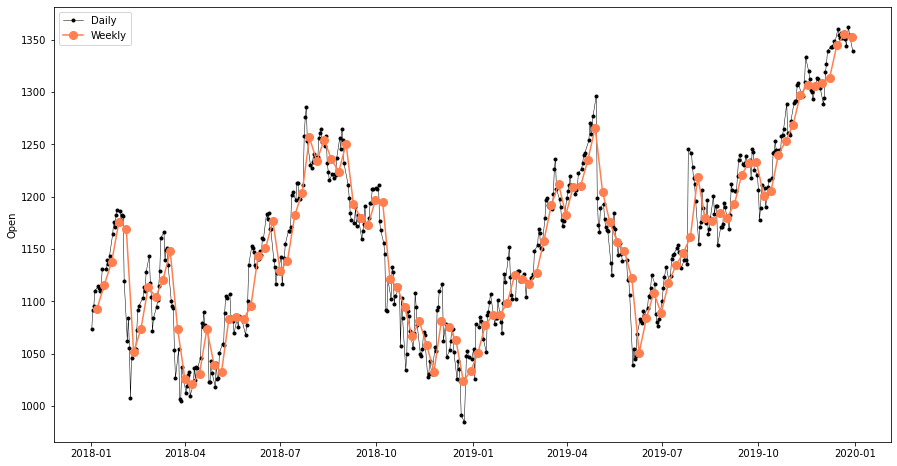

In [11]:
start = "2018-01-01"
end = "2019-12-31"

fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(data.loc[start:end, 'Close'], marker='.', linestyle='-', linewidth = 0.5, label='Daily', color='black')
ax.plot(df_week.loc[start:end, 'Close'], marker='o', markersize=8, linestyle='-', label='Weekly', color='coral')
ax.set_ylabel("Open")
ax.legend()

Before attempting time series modeling we need to consider stationarity of our series. I will asses it using ACF and PACF charts. 

An ACF measures and plots the average correlation between data points in a time series and previous values of the series measured for different lag lengths 

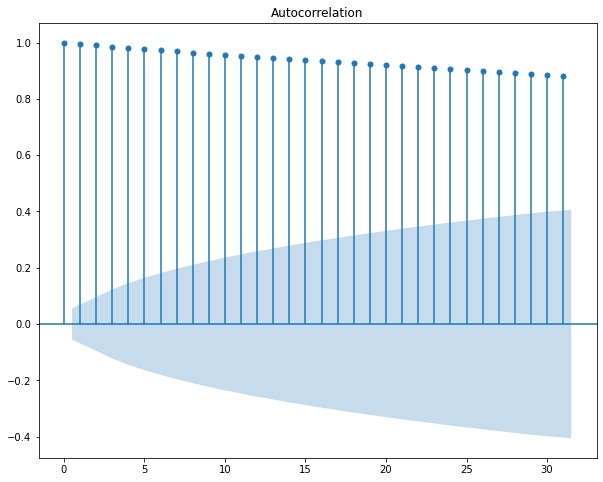

In [12]:
plt.rc("figure", figsize=(10,8))
sm.graphics.tsa.plot_acf(data.Close);

A PACF is similar to an ACF except that each correlation controls for any correlation between observations of a shorter lag length

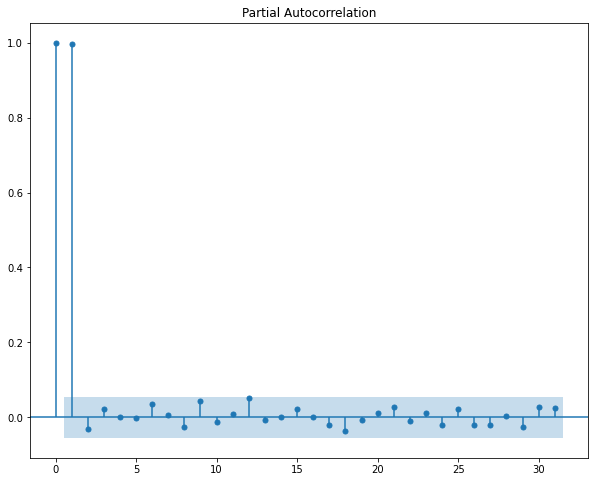

In [13]:
plt.rc("figure", figsize=(10,8))
sm.graphics.tsa.plot_pacf(data.Close);

As the ACF declines more slowly toward zero and the PACF has relatively large spikes at the first and second lags before dropping off to near zero, the series might be better characterized as an AR(2) process, meaning correlation at both the first and second lags of the series

### Model training

#### ARIMA

AutoRegressive Integrated Moving Average (ARIMA) model is a widely used forecasting method for time-series prediction. I will deploy it as our first model.

Based on the ACF and PACF charts we can assume that parameter d should be set to two (number of nonseasonal differences needed for stationarity). The rest of parameters will be found using an Auto Arima funcion, which tests the time series with different combinations of p, d, and q using AIC as the criterion. AIC stands for Akaike Information Criterion, which estimates the relative amount of information lost by a given model. In simple terms, a lower AIC value is preferred. 

In [14]:
model_autoARIMA = auto_arima(data["Close"], start_p=0, start_q=0,
                      test='adf',
                      max_p=2, max_q=3,
                      m=1,             
                      d=2,           
                      seasonal=False,   
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=11045.041, Time=0.09 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=10763.362, Time=0.33 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.68 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=11043.041, Time=0.04 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=10586.258, Time=0.28 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.47 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.03 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=10584.258, Time=0.16 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=10761.363, Time=0.14 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.73 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.58 sec

Best model:  ARIMA(2,2,0)(0,0,0)[0]          
Total fit time: 5.522 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1258
Model:         

The output above shows that the final model fitted was an ARIMA(2,2,0) estimator, where the values of the parameters p, d, and q were two, two, and zero, respectively. In the above output, the lowest AIC value of 10207.731 was obtained for the ARIMA(2, 2, 0) model, and that is used as the final estimator.

It is important we do not randomly split training and testing datasets. In stock price prediction, we have to use the test data always the recent dataset give a better result for our prediction

I AM implement a rolling forecasting procedure, given the dependence on observations in prior time steps for differencing the AR model.

In [15]:
train_data, test_data = data[0:int(len(data)*0.8)], data[int(len(data)*0.8):]
train_data = train_data['Close'].values
test_data = test_data['Close'].values

history = [x for x in train_data]
model_predictions = []
N_test_observations = len(test_data)
p = 2 # Number of lag observations included
d = 2 # Degree of differencing
q = 0 # Span of the moving average windon


for time_point in range(N_test_observations):
    model = ARIMA(history, order=(p,d,q))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = test_data[time_point]
    history.append(true_test_value)
    
MSE_error = mean_squared_error(test_data, model_predictions)
print('Testing Mean Squared Error is {}'.format(MSE_error))

Testing Mean Squared Error is 436.9402680128193


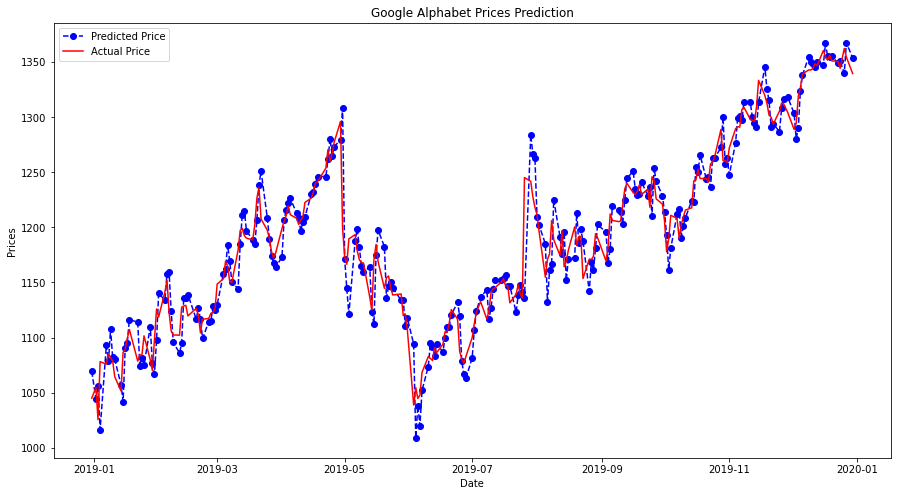

In [16]:
test_set_range = data[int(len(data)*0.8):].index
plt.rc("figure", figsize=(15,8))
plt.plot(test_set_range, model_predictions, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
plt.plot(test_set_range, test_data, color='red', label='Actual Price')
plt.title('Google Alphabet Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.xticks()
plt.legend()
plt.show()

With a Testing Mean Squared Error of 436.94, ARIMA provides quite accurate prediction accuracy, compared to the relatively fast performance. 

#### LSTM

Long Short Term Memory networks – usually just called “LSTMs” – are a special kind of RNN, capable of learning long-term dependencies. LSTM cell can learn to recognize an important input (that’s the role of the input gate), store it in the long-term state, preserve it for as long as it is needed (that’s the role of the forget gate), and extract it whenever it is needed. This explains why these cells have been amazingly successful at capturing long-term patterns in time series, long texts, audio recordings, and more.

LSTM cell image

Dividing into train and test into 80%/20% split

In [17]:
cl = data.Close.astype('float32')
train = cl[0:int(len(cl)*0.80)]

Before modelling we normalize our data using scikit-learn's MinMaxScaler. All features will be transformed into the range [0,1] meaning that the minimum and maximum value of a feature/variable is going to be 0 and 1, respectively.

In [18]:
#Scale the data
scl = MinMaxScaler()
scl.fit(train.values.reshape(-1,1))
cl =scl.transform(cl.values.reshape(-1,1))

#### Building input features for model

The LSTM model will learn a function that maps a sequence of past observations as input to an output observation. As such, the sequence of observations must be transformed into multiple examples from which the LSTM can learn.

We can divide the sequence into multiple input/output patterns called samples, where X time steps are used as input and one time step is used as output for the one-step prediction that is being learned. In our case we will specify this timestamp lookback value at 10 observatins. By doing this we are turning a data into supervised learning problem, when each value is determied by previous 10 observations.

In [19]:
def processData(data,lb):
    X,Y = [],[]
    for i in range(len(data)-lb-1):
        X.append(data[i:(i+lb),0])
        Y.append(data[(i+lb),0])
    return np.array(X),np.array(Y)
lb=10 # How many values back we will consider to calculate next value
X,y = processData(cl,lb)
X_train,X_test = X[:int(X.shape[0]*0.80)],X[int(X.shape[0]*0.80):]
y_train,y_test = y[:int(y.shape[0]*0.80)],y[int(y.shape[0]*0.80):]
print(X_train.shape[0],X_train.shape[1])
print(X_test.shape[0], X_test.shape[1])

997 10
250 10


#### Vanilla LSTM

First we will construct a Vanilla LSTM - a model that has a single hidden layer of LSTM units, and an output layer used to make a prediction

The shape of the input for each sample is specified in the *input_shape* argument on the definition of first hidden layer.
The number of time steps as input is the number we chose when preparing our dataset. We are working with a univariate series, so the number of features is one, for one variable. 

Next we define a model with 50 LSTM units in the hidden layer and an output layer that predicts a single numerical value.
The model is fit using the efficient Adam version of stochastic gradient descent and optimized using the mean squared error, or ‘mse‘ loss function.

In [20]:
#Build the model
model = Sequential()
model.add(LSTM(50,input_shape=(lb,1)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

#Reshape data for (Sample,Timestep,Features) 
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))

history = model.fit(X_train,y_train,epochs=100,validation_data=(X_test,y_test),shuffle=False,verbose=0)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [21]:
train_predict = scl.inverse_transform(model.predict(X_train))
test_predict = scl.inverse_transform(model.predict(X_test))

In [22]:
print('Training Mean Squared Error is: %.3f' % math.sqrt(mean_squared_error(y_train,train_predict)))
print('Testing Mean Squared Error is: %.3f' % math.sqrt(mean_squared_error(y_test,test_predict)))

Training Mean Squared Error is: 905.294
Testing Mean Squared Error is: 1194.491


Text(0.5, 1.0, 'Train Dataset')

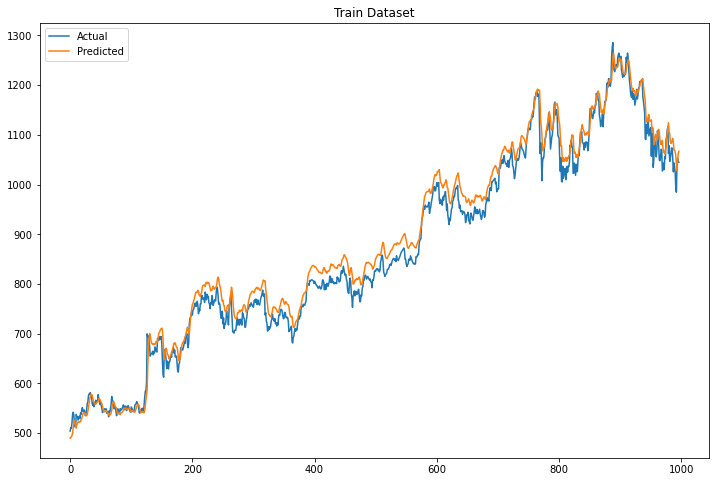

In [23]:
plt.figure(figsize=(12,8))
Xt = model.predict(X_train)
plt.plot(scl.inverse_transform(y_train.reshape(-1,1)), label="Actual")
plt.plot(scl.inverse_transform(Xt), label="Predicted")
plt.legend()
plt.title("Train Dataset")

Text(0.5, 1.0, 'Test Dataset')

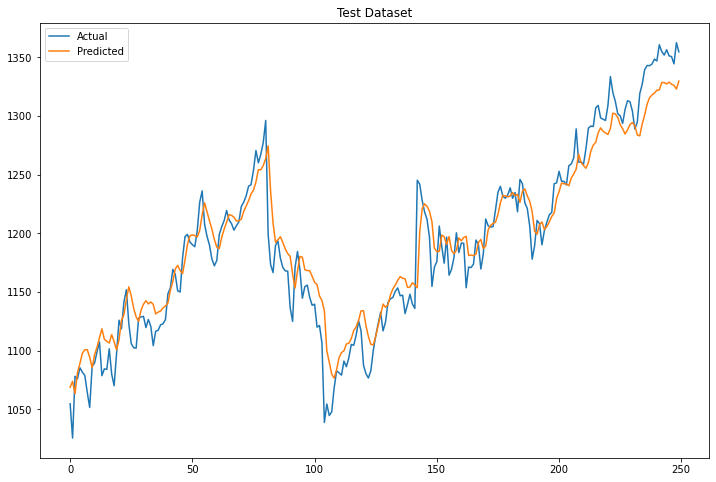

In [24]:
plt.figure(figsize=(12,8))
test_predict = model.predict(X_test)
plt.plot(scl.inverse_transform(y_test.reshape(-1,1)), label="Actual")
plt.plot(scl.inverse_transform(test_predict), label="Predicted")
plt.legend()
plt.title("Test Dataset")

#### Stacked LSTM model

As a second model, I will be considering a more complicated stacked LSTM architecture. The model will consist of four LSTM layers with a dropout regularisation between them and an output layer. In case of stacked LSTM layers, I set return_sequences=True, so that each next LSTM layer has a three-dimensional sequence input. I will train the network on 200 epochs. 

In [25]:
### 2nd Model
model = Sequential()
#First LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
# Adding a second stacked LSTM layer and dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a third stacked LSTM layer and dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a fourth stacked LSTM layer and dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')
# Fitting the RNN to the Training set

#Reshape data for (Sample,Timestep,Features) 
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))

history = model.fit(X_train,y_train,epochs=200,validation_data=(X_test,y_test),shuffle=False,verbose=0)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 10, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 10, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 50)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)               

In [26]:
train_predict = scl.inverse_transform(model.predict(X_train))
test_predict = scl.inverse_transform(model.predict(X_test))

In [27]:
print('Training Mean Squared Error is: %.3f' % math.sqrt(mean_squared_error(y_train,train_predict)))
print('Testing Mean Squared Error is: %.3f' % math.sqrt(mean_squared_error(y_test,test_predict)))

Training Mean Squared Error is: 873.008
Testing Mean Squared Error is: 1144.439


Text(0.5, 1.0, 'Train Dataset')

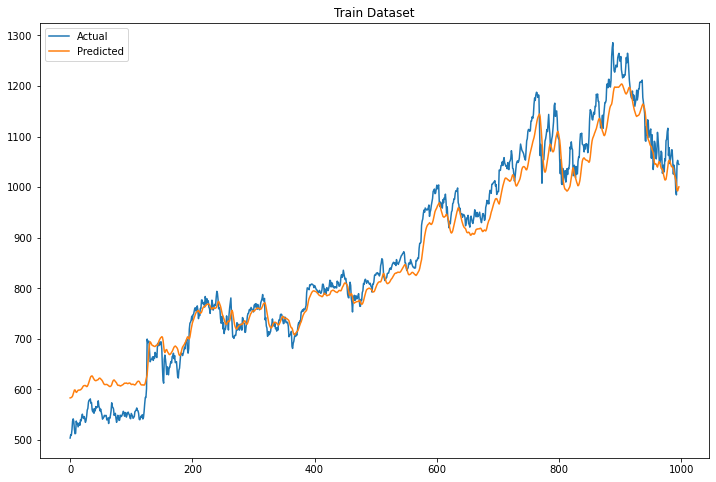

In [28]:
plt.figure(figsize=(12,8))
Xt = model.predict(X_train)
plt.plot(scl.inverse_transform(y_train.reshape(-1,1)), label="Actual")
plt.plot(scl.inverse_transform(Xt), label="Predicted")
plt.legend()
plt.title("Train Dataset")

Text(0.5, 1.0, 'Test Dataset')

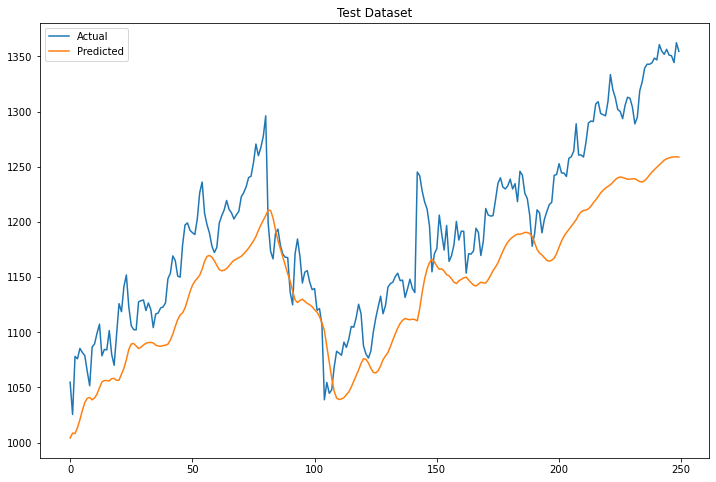

In [29]:
plt.figure(figsize=(12,8))
test_predict = model.predict(X_test)
plt.plot(scl.inverse_transform(y_test.reshape(-1,1)), label="Actual")
plt.plot(scl.inverse_transform(test_predict), label="Predicted")
plt.legend()
plt.title("Test Dataset")

Compared to the simple LSTM model with only one layer, we receive worse results on train but better as on test set, as measured by MSE. 

#### Facebook Prophet

As a third approach to predicting stock prices, I will use the Facebook Prophet procedure. The prophet is an open-source library published by Facebook that is based on decomposable (trend+seasonality+holidays) models. It provides us with the ability to make time-series predictions with good accuracy using simple intuitive parameters

In [30]:
# Convert rowname to a variable and values to float
data_fb = data[["Close"]]
data_fb = data_fb.reset_index()
# Rename the features: These names are NEEDED for the model fitting
data_fb = data_fb.rename(columns = {"Date":"ds","Close":"y"}) #renaming the columns of the dataset

In [31]:
#Spliting data into test and train

train_data_fb, test_data_fb = data_fb[0:int(len(data_fb)*0.8)], data_fb[int(len(data_fb)*0.8):]

In [32]:
m = Prophet(daily_seasonality = True) # the Prophet class (model)
m.fit(train_data_fb) # fit the model using all data

In [33]:
future = DataFrame(test_data_fb['ds'])

In [34]:
forecast = m.predict(future)

In [35]:
# calculate MAE between expected and predicted values for 
y_true = test_data_fb['y'].values
y_pred = forecast['yhat'].values
mae = mean_absolute_error(y_true, y_pred)
print('Testing Mean Squared Error is: %.3f' % mae)

Testing Mean Squared Error is: 99.435


Facebook prophet offers relatively accurate prediction, compared to two previous methods. 

#### Using prophet to predict prices in next year

We can also deploy Prophet to forecast stock prices in a specified future timeframe, in this example we will perform a forecast for 2020.

In [36]:
from fbprophet import Prophet
m = Prophet(daily_seasonality = True)
m.fit(data_fb) # fit the model using all data

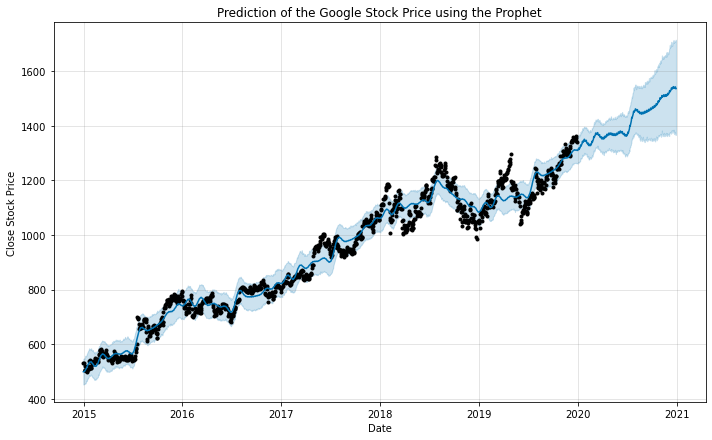

In [37]:
future = m.make_future_dataframe(periods=365) #we need to specify the number of days in future
prediction = m.predict(future)
m.plot(prediction)
plt.title("Prediction of the Google Stock Price using the Prophet")
plt.xlabel("Date")
plt.ylabel("Close Stock Price")
plt.show()

### Conclusions

Time-series forecasting, especially involving stock market price prediction, has proven to one of the most challenging tasks to accomplish in financial forecasting due to the complex nature of the stock market and a high dose of randomness.
By applying statistical modeling, we can try to undercover some stock price dynamics and gain precious insights into financial markets' inner workings.

This can be achieved by applying classical methods like ARIMA, novel deep learning methods like LSTM, or decomposable models like Facebook Prophet. The best results measured by the Mean Squared Error (MSE) were achieved by applying the Facebook Prophet decomposable model in the example presented above. ARIMA yielded better results than the novel LSTM approach. LSTM results could be improved by performing more thorough fine hyperparameters tunning, using methods like GridSearch, and including lag observations as input features or specifying architecture to ensure non-stationarities are learned and effectively predicted by LSTMs.